# Fine-tuning Models

In this notebook, we will use an existing ResNet50 model to classify images. [ResNet50](https://arxiv.org/abs/1512.03385v1) is a well-known and widely used model for image classification. A version of this model pre-trained on millions of images of the [ImageNet](https://www.image-net.org/) database can be downloaded from the several places. We are going to use the well-known [HuggingFace](https://huggingface.co/) model repository.

The idea of fine-tuning is as follows: you download weights trained on another large dataset, in this case ImageNet, and you use those weights as a starting point for your training. Training the model with these existing weights allows training on much smaller datasets and in a lot less time. The idea is that the model can use the knowledge it learned when it was trained on the large dataset and benefit from that. This will work in almost all cases, even if your dataset is not so similar to the one the model originally was trained on. In contrast, the closer the dataset will be to the large dataset, the easier the training. We will show this in this notebook too.

In [1]:
!pip install datasets evaluate "transformers[torch]"
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 6.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.24.1
    Uninstalling accelerate-0.24.1:
      Successfully uninstalled accelerate-0.24.1


In [2]:
%env DATA_DIRECTORY=/content

env: DATA_DIRECTORY=/content


In [3]:
!wget "https://zenodo.org/records/7551799/files/DeepStat-WP5-dataset.zip?download=1" -O "$DATA_DIRECTORY/DeepStat-WP5-dataset.zip"

/content/DeepStat-WP5-dataset.zip: No such file or directory


In [4]:
!mkdir -p $DATA_DIRECTORY/DeepStat

!unzip "$DATA_DIRECTORY/DeepStat-WP5-dataset.zip" -d "$DATA_DIRECTORY/DeepStat"

mkdir: /content: Read-only file system


unzip:  cannot find or open /content/DeepStat-WP5-dataset.zip, /content/DeepStat-WP5-dataset.zip.zip or /content/DeepStat-WP5-dataset.zip.ZIP.


First, we will have to specify the path to the data.

In [5]:
import os

data_directory = os.getenv('DATA_DIRECTORY')
data_directory

'/content'

In [6]:
# do feature extraction from these images using a resnet50 model from huggingface
import torch
import torch.nn as nn
from transformers import AutoImageProcessor, ResNetModel

def get_features_from_model(processor, model, images):
    inputs = processor(images, return_tensors="pt").to(model.device)

    # Extract features
    with torch.no_grad():
        features = model(**inputs).pooler_output.squeeze()
        return features

def get_resnet_features(images):
    # Load the model
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
    model = ResNetModel.from_pretrained("microsoft/resnet-50")
    model.to(device)
    return get_features_from_model(processor, model, images)



/Users/timdejong/.pyenv/versions/3.11.4/envs/ai_course/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


def tsne_plot(features, labels):
    # Convert features tensor to numpy array
    features_np = features.cpu().numpy()

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    features_2d = tsne.fit_transform(features_np)

    # Create a scatter plot
    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='coolwarm')

    # Add a color bar
    plt.colorbar(scatter)

    plt.show()


# Cats vs. Dogs

First, we will see how a ResNet50 trained on ImageNet, will perform on a dataset that contains images that are similar to the images in ImageNet. We will download a dataset from [HuggingFace](https://huggingface.co) that contains images of Cats and Dogs. We want to use the model to classify whether an image contains a Cat or a Dog. Within the large collection of images in ImageNet, there are already thousands of images of cats and dogs, but also thousands in other categories. A model trained on ImageNet already learned to distinguish between Cats and Dogs. Therefore, the task won't need any fine-tuning. First, we will download the dataset:

In [8]:
from datasets import load_dataset

dataset = load_dataset("cats_vs_dogs", split="train")
print(dataset)

Dataset({
    features: ['image', 'labels'],
    num_rows: 23410
})


In [9]:
cats_and_dogs_df = dataset.to_pandas()
cats_and_dogs_df["filename"] = cats_and_dogs_df["image"].apply(lambda image: image["path"])
cats_sample_df = cats_and_dogs_df.sample(500)
cats_sample_df

image  labels  \
16673  {'bytes': None, 'path': '/Users/timdejong/.cac...       1   
16410  {'bytes': None, 'path': '/Users/timdejong/.cac...       1   
22792  {'bytes': None, 'path': '/Users/timdejong/.cac...       1   
12929  {'bytes': None, 'path': '/Users/timdejong/.cac...       1   
5628   {'bytes': None, 'path': '/Users/timdejong/.cac...       0   
...                                                  ...     ...   
13411  {'bytes': None, 'path': '/Users/timdejong/.cac...       1   
16575  {'bytes': None, 'path': '/Users/timdejong/.cac...       1   
3097   {'bytes': None, 'path': '/Users/timdejong/.cac...       0   
8188   {'bytes': None, 'path': '/Users/timdejong/.cac...       0   
22935  {'bytes': None, 'path': '/Users/timdejong/.cac...       1   

                                                filename  
16673  /Users/timdejong/.cache/huggingface/datasets/d...  
16410  /Users/timdejong/.cache/huggingface/datasets/d...  
22792  /Users/timdejong/.cache/huggingface/datasets/d...  
12929  /Users/timdejong/.cache/huggingface/datasets/d...  
5628   /Users/timdejong/.cache/huggingface/datasets/d...  
...                                                  ...  
13411  /Users/timdejong/.cache/huggingface/datasets/d...  
16575  /Users/timdejong/.cache/huggingface/datasets/d...  
3097   /Users/timdejong/.cache/huggingface/datasets/d...  
8188   /Users/timdejong/.cache/huggingface/datasets/d...  
22935  /Users/timdejong/.cache/huggingface/datasets/d...  

[500 rows x 3 columns]

Let's load all the images into memory:

In [10]:
from PIL import Image
import random

# Load the images
images = [Image.open(filename).convert('RGB') for filename in cats_sample_df["filename"]]


And visualize some of them. Each time you run this cell a random picture from the dataset should be displayed:

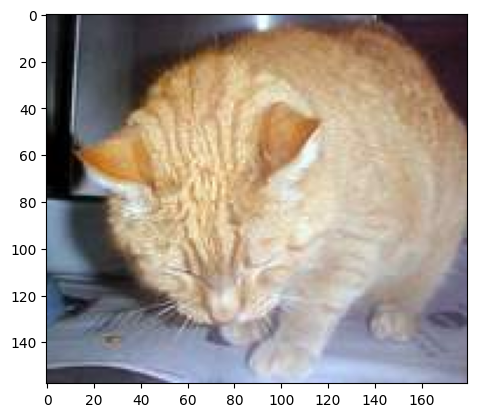

In [11]:
plt.imshow(images[random.randint(0, len(images)-1)])

One way deep-learning algorithms differ from traditional machine learning models, is that they also learn feature extraction on the data. In contrast, in traditional machine learning, the data scientist need to look for suitable features themselves. Schematically, this looks like this ![Traditional machine learning vs. deep-learning](./traditional_vs_deep_learning.png)


Good features separate the classes you want to label the best. If we look at a deep-learning model in more detail, we see that often a lot of the layers in the model are aimed at feature extraction. After those layers often a small classifier performs the classification between the classes. This can be a simple as a logistic regression. This image shows the structure of a lot of image classification models:


<img src="./applsci-10-03359-g001.png" alt="Feature extraction and classification in deep learning" style="width: 50%;"/>

<!-- [Source](https://www.mdpi.com/2076-3417/10/10/3359) -->

The feature layers of the model take the image and map the image into a certain combination of numbers called a feature vector. Basically, the model tries to put the image in a certain location in a highly dimensional space. The location is described by the combination of numbers given by the feature vector. When we take only the first layers of the model responsible for this feature extraction, we can extract these image "locations" and try to visualize them.

In [12]:
cats_features = get_resnet_features(images)
print(cats_features.shape)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


torch.Size([500, 2048])


Now we have all the locations for all of the images in the dataset, we can visualize them. Of course, it is difficult to visualize a high dimensional space. Instead, we perform a dimension reduction technique called `TSNE` that maps the locations in the high dimensional feature space to a 2D space that we can visualize:

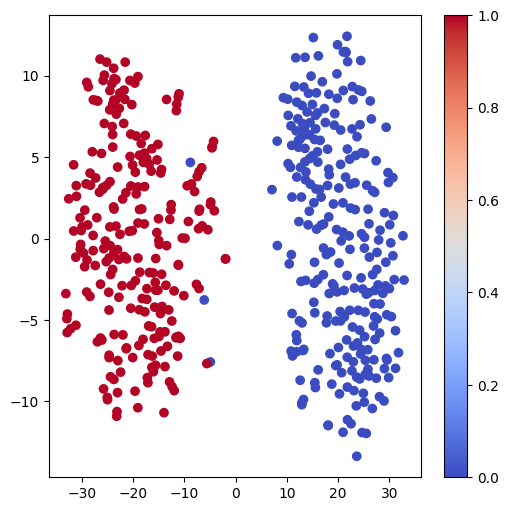

In [13]:
# Assuming binary_classes is a list of your binary classes
cats_labels = cats_sample_df["labels"].tolist()
tsne_plot(cats_features, cats_labels)

In the picture above, we can clearly see that the two classes, Cats and Dogs, are clearly separated. There's a blue cluster and a red cluster of points. This indicates that the ResNet 50 model that we downloaded can easily separate these two classes of images. This is no surprise as there are thousands of images containing cats and dogs in the ImageNet dataset it was trained on. We can see that there are some blue points within the red cluster, and also some red points in the blue cluster. These are images that are harder to classify, maybe cats that look like dogs, dogs that look like cats, or images with both cats and dogs.

In general, the model looks like it does a pretty good job though. This can also be seen when we train a simple logistic regression model on the feature vectors we extracted:

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split the data into train and test sets
train_features_cats, test_features_cats, train_labels_cats, test_labels_cats = train_test_split(cats_features.cpu(), cats_labels, test_size=0.2, random_state=42)

lr_model = LogisticRegression()
lr_model.fit(train_features_cats, train_labels_cats)

# Make predictions
predictions = lr_model.predict(test_features_cats)

# Print classification report
print(classification_report(test_labels_cats, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           1       1.00      1.00      1.00        44

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



From the classification report, we can see that the model has very high performance. Indeed, the ResNet 50 model can easily learn to distinguish between the two classes, based on what it learned when it was trained on ImageNet.

# Detecting Solar Panels

Cats and dogs were easy for our model. What would happen if we try to train the model to classify something it hasn't seen before. Instead of natural pictures that are present in the ImageNet database, we are now presenting the model with Earth Observation photographs, which are not part of ImageNet. We will try to distinguish whether there are solar panels or not in the picture.

In [15]:
import pandas as pd

solar_data_directory = os.path.join(data_directory, "DeepStat/selected/")
annotations_df = pd.read_csv(os.path.join(solar_data_directory, "all_annotations.csv"), sep=";")
annotations_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/DeepStat/selected/all_annotations.csv'

In [ ]:
annotations_df["filename"] = annotations_df["filename"].apply(lambda original_filename: os.path.join(solar_data_directory, original_filename[1:]))
annotations_df.head()

user_id  dataset_id   region  year image_quality image_pixel_resolution  \
0        1           1  Heerlen  2018            HR                200x200   
1        1           1  Heerlen  2018            HR                200x200   
2        1           1  Heerlen  2018            HR                200x200   
3        1           1  Heerlen  2018            HR                200x200   
4        1           1  Heerlen  2018            HR                200x200   

                             image_uuid  \
0  00009ae2-f851-4fd9-8a2a-2ac517df9b95   
1  0001a16c-6798-4b20-b0ff-21745d2bf177   
2  00026530-22b0-4124-8a57-4f65e83ea82a   
3  001381b4-9b66-4443-8f84-7275d30cac0e   
4  0023bf05-a166-4049-8148-f4409966b052   

                                            filename  defaultAnnotation  \
0  /content/DeepStat/selected/Heerlen_2018_HR/ful...                  0   
1  /content/DeepStat/selected/Heerlen_2018_HR/ful...                  0   
2  /content/DeepStat/selected/Heerlen_2018_HR/ful...                  0   
3  /content/DeepStat/selected/Heerlen_2018_HR/ful...                  0   
4  /content/DeepStat/selected/Heerlen_2018_HR/ful...                  0   

   annotation  annotation_created_date  annotation_updated_date  
0           0  2019-08-15 14:58:34.371  2019-08-15 14:58:34.371  
1           0  2019-08-03 11:38:47.622  2019-08-03 11:38:47.622  
2           0  2019-08-03 10:44:24.868  2019-08-03 10:44:24.868  
3           0  2019-08-15 15:20:17.869  2019-08-15 15:20:17.869  
4           0  2019-08-03 10:27:44.940  2019-08-03 10:27:44.940

Let's explore some images with a negative label, i.e. the image does not contain any solar panels. Every time you run the cell below another image should be displayed.

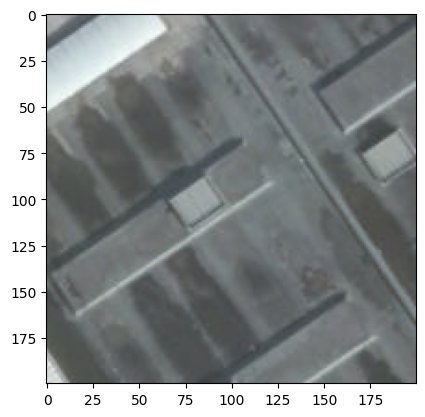

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

negative_images = annotations_df[annotations_df.annotation == 0].reset_index(drop=True)
plt.imshow(imread(negative_images["filename"].iloc[random.randint(0, len(negative_images) - 1)]))

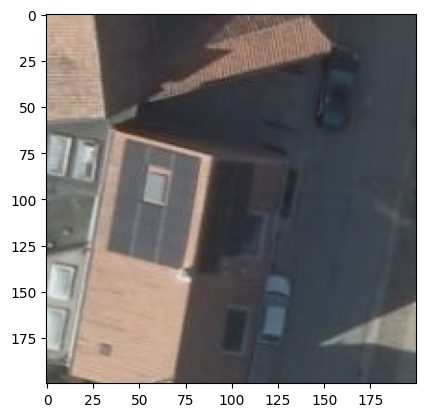

In [ ]:
positive_images = annotations_df[annotations_df.annotation == 1].reset_index(drop=True)
plt.imshow(imread(positive_images["filename"].iloc[random.randint(0, len(positive_images) - 1)]))

The solar panel dataset is quite large. Extracting features for all the images will take a lot of time. Let's take a sample of 1000 images instead.

In [ ]:
sample_df = annotations_df.sample(500)
sample_df.head()

user_id  dataset_id   region  year image_quality  \
18491         1           2       ZL  2018            HR   
93365         2           2       ZL  2018            HR   
139542       15           1  Heerlen  2018            HR   
177219       26           2       ZL  2018            HR   
56648         2           2       ZL  2018            HR   

       image_pixel_resolution                            image_uuid  \
18491                 200x200  1ff83420-79ac-45b5-8120-ce327071059a   
93365                 200x200  fff1ce42-9b18-4d10-96a8-b4a7d1f4b830   
139542                200x200  36f5cacf-c76c-49f0-9dc8-a33944d0f9ab   
177219                200x200  20b132c7-78c4-4111-bf34-bffc4e5d8315   
56648                 200x200  115e2180-b33b-490c-b46b-28739bbd2da7   

                                                 filename  defaultAnnotation  \
18491   /content/DeepStat/selected/ZL_2018_HR/full/1ff...                  1   
93365   /content/DeepStat/selected/ZL_2018_HR/full/fff...                  0   
139542  /content/DeepStat/selected/Heerlen_2018_HR/ful...                  0   
177219  /content/DeepStat/selected/ZL_2018_HR/full/20b...                  0   
56648   /content/DeepStat/selected/ZL_2018_HR/full/115...                  0   

        annotation  annotation_created_date  annotation_updated_date  
18491            1  2019-08-03 12:40:20.054  2019-08-03 12:40:20.054  
93365            0  2019-08-09 06:34:08.918  2019-08-09 06:34:08.918  
139542           0  2019-08-21 13:15:15.448  2019-08-21 13:15:15.448  
177219           0  2020-07-21 13:38:44.012  2020-07-21 13:38:44.012  
56648            0  2019-08-09 07:07:03.798  2019-08-09 07:07:03.798

We will load these images into memory now.

In [ ]:
# Load the images
images = [Image.open(filename).convert('RGB') for filename in sample_df["filename"]]
solar_features = get_resnet_features(images)
print(solar_features.shape)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


torch.Size([750, 2048])


And visualize these features, just like we did with the Cats and Dogs dataset.

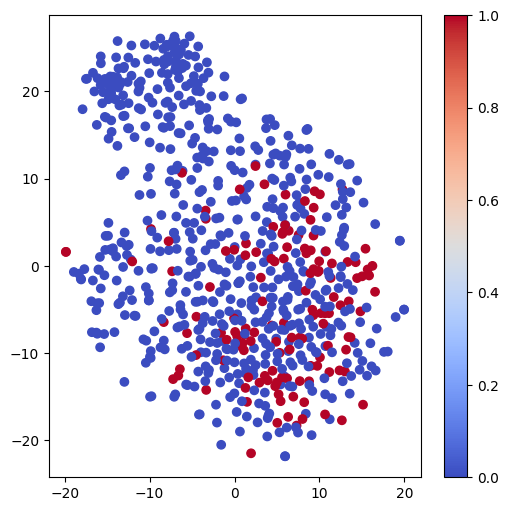

In [ ]:
solar_labels = sample_df["annotation"].tolist()
tsne_plot(solar_features, solar_labels)

In [ ]:
# Split the data into train and test sets
train_solar_features, test_solar_features, train_solar_labels, test_solar_labels = train_test_split(solar_features.cpu(), solar_labels, test_size=0.2, random_state=42)

lr_model = LogisticRegression()
lr_model.fit(train_solar_features, train_solar_labels)

# Make predictions
solar_predictions = lr_model.predict(test_solar_features)

# Print classification report
print(classification_report(test_solar_labels, solar_predictions))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       126
           1       0.70      0.58      0.64        24

    accuracy                           0.89       150
   macro avg       0.81      0.77      0.79       150
weighted avg       0.89      0.89      0.89       150



Here we see that the model has a lot more trouble identifying the positive cases, i.e. the photographs with a solar panel. To improve performance, we need to fine-tune the model to our solar panel dataset.

# Fine-tuning the model

To fine tune the model, we need to train the model further on the dataset containing the Earth Observation images and their labels. We use the original ResNet 50 as a starting point and train the model a couple of more iterations. After fine tuning the model should be able to separate the "solar panel" and "no solar panel" classes a lot better.

To fine-tune the model, we need to choose a performance metric used when training. In this case, we are using the widely used F1 metric.

In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("f1")

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

Before fine-tuning, we need to prepare the dataset so it can be used by the Hugging Face package. We also select as sub-sample of 10000 images. Otherwise training will take too long.

In [ ]:
from datasets import Dataset, DatasetInfo, Image, Features, ClassLabel,ImageClassification

solar_df = annotations_df[['filename', 'annotation']].rename(columns={'filename': 'image','annotation': 'label'})
solar_df = solar_df.sample(5000).reset_index(drop=True)

features = Features({"image": Image(), "label": ClassLabel(num_classes=2, names=["negative", "positive"])})
dataset_info = DatasetInfo(supervised_keys=("image", "label"), features=features, task_templates=[ImageClassification(image_column="image", label_column="label")])

dataset = Dataset.from_pandas(solar_df, info=dataset_info).cast_column("image", Image())

Before the model can use the images, we need to pre-process them. We will also add some random changes to the images. This often leads to models that can predict better on unseen images, and is called `data augmentation`.

In [ ]:

from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, Compose, Normalize, ToTensor

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
size = (
    processor.size["shortest_edge"]
    if "shortest_edge" in processor.size
    else (processor.size["height"], processor.size["width"])
)

# Add random distortions to the images to improve training
_transforms = Compose([RandomResizedCrop(size),
    RandomHorizontalFlip(p=0.4),
    RandomVerticalFlip(p=0.2),
    RandomRotation(degrees=4),
    ToTensor(), normalize])

def transform(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

#dataset.set_transform(transform)
dataset = dataset.with_transform(transform)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


After preparing the data, we split it in a training set and a test set. Here we use 80% of the sample of 10000 images as training set, and 20% as test set.

In [ ]:
# Split the data into train and test sets
dataset = dataset.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

After we created a training set and a test set, we need to set up the training. Here we want to fine-tune the model in 15 epochs and a batch size of 64. Deep-learning models are trained incrementally. That means that we offer them a small sample, or mini-batch, of training data, train them, and then continue with the next sample/mini-batch. In this case, we offer the ResNet model 64 images per iteration. We continue this process until we ran through all the training data. This is called an epoch. In total, we train the model for 15 epochs. That means we run through the complete training set 15 times.

Next to the `number of epochs` and the `batch size`, there are also other settings we can use to influence model training. Another important one is the `learning rate`. These settings are called `hyper-parameters`. You will find that you will often use most time to choose hyper-parameters that work well. Luckily, the Hugging Face package provides us with an automatic way of optimize the `hyper-parameters`.

In [ ]:
from transformers import TrainingArguments

batch_size = 64
number_of_epochs = 15

training_args = TrainingArguments(
    output_dir="test_trainer",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-3,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=number_of_epochs,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    push_to_hub=False
)

Last, we prepare the model. A standard ResNet model is trained on an ImageNet dataset that has 1000 different classes. Here, we are only trying to predict two classes: the presence or the absence of solar panels. Therefore, we have to slightly change the classifier of the image. After that, we prepare the HuggingFace `Trainer` class that will perform the fine-tuning for us.

In [ ]:
from transformers import Trainer, DefaultDataCollator, ResNetForImageClassification
import torch.nn as nn


# Setup model fine-tuning
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
# Normally ResNet classifies 1000 classes, now we need only 2
model.num_labels = 2
# We also need to adapt the classifier to classify only 2 classes
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(2048, 2)
)

data_collator = DefaultDataCollator(return_tensors="pt")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
    compute_metrics=compute_metrics
)

Now it is time to fine-tune the model. We use the solar panel dataset to update the weights of the ResNet model for a further 10 epochs. After training, the model should be optimized further to recognized the presence or absence of solar panels. Training will take a bit of time. The more epochs and the bigger the dataset, the longer the training will take.

In [ ]:
# Fine-tune
trainer.train()

TrainOutput(global_step=225, training_loss=0.278957130379147, metrics={'train_runtime': 969.0115, 'train_samples_per_second': 61.919, 'train_steps_per_second': 0.232, 'total_flos': 1.2136457767079117e+18, 'train_loss': 0.278957130379147, 'epoch': 14.29})

After training, we first evaluate the fine-tuned model on our test set. We let it predict a class for each image in the test set.

In [ ]:
# Evaluate
solar_predictions_fine_tuned = trainer.predict(dataset["test"])

Let's see what the label distribution in the test set looks like. We see the majority of the images do not have a solar panel (label 0).

In [ ]:
solar_fine_tune_labels = dataset["test"].to_pandas().label.values
pd.Series(solar_fine_tune_labels).value_counts()

0    825
1    175
dtype: int64

We can compare this to the label distribution of our predictions. We see that the model predicts slightly different amounts of images with a solar panel (label 1) and without a solar panel (label 0)

In [ ]:
solar_fine_pred = solar_predictions_fine_tuned.predictions.argmax(axis=-1)
pd.Series(solar_fine_pred).value_counts()

0    884
1    116
dtype: int64

To see how well the model predicts solar panels, we use the `sklearn classification_report` function. We can compare this classification report with the one that we provided above, when we trained a `LogisticRegression` classifier on the features extracted by a standard ResNet model.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(solar_fine_tune_labels, solar_fine_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       825
           1       0.92      0.61      0.74       175

    accuracy                           0.92      1000
   macro avg       0.92      0.80      0.85      1000
weighted avg       0.92      0.92      0.92      1000



Compare this to the classification report from above, and we see that in general the fine-tuned model performs better. However, the test set we were using before contains different and a lot less pictures than the one we are using above.

In [ ]:
print(classification_report(test_solar_labels, solar_predictions))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       126
           1       0.70      0.58      0.64        24

    accuracy                           0.89       150
   macro avg       0.81      0.77      0.79       150
weighted avg       0.89      0.89      0.89       150



If we use the same images, we see a different story. First preprocess the images:

In [ ]:
inputs = processor(images, return_tensors="pt")

Then extract the features from our fine-tuned model:

In [ ]:
with torch.no_grad():
    fine_tuned_model = trainer.model.to("cpu")
    fine_tuned_features = fine_tuned_model.resnet(**inputs).pooler_output.squeeze()

In [ ]:
fine_tuned_features

So that we can visualize them with a TSNE.

In [ ]:
tsne_plot(fine_tuned_features, solar_labels)

Here it becomes clear that the model has learned to separate the solar panel/no solar panel classes a lot better. If we train a logistic regression on these features, we also see that it performs a lot better than the logistic regression we trained on the original (not fine-tuned) ResNet features. This shows that fine-tuning makes a model learn new features, so that it can perform new tasks, i.e recognize previously unseen image classes, a lot more effectively. In addition, fine-tuning is a lot faster than training a model from scratch.

In [ ]:
# Split the data into train and test sets
train_fine_tuned_features, test_fine_tuned_features, train_fine_tuned_labels, test_fine_tuned_labels = train_test_split(fine_tuned_features, solar_labels, test_size=0.2, random_state=42)

lr_model = LogisticRegression()
lr_model.fit(train_fine_tuned_features, train_fine_tuned_labels)

# Make predictions
fine_tuned_predictions = lr_model.predict(test_fine_tuned_features)

# Print classification report
print(classification_report(test_fine_tuned_labels, fine_tuned_predictions))